In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import cv2, os, math, time
from datetime import timedelta
from sklearn.utils import shuffle
from numpy.lib.stride_tricks import as_strided

### Configuration

In [2]:
###Configuration
"""
Data Configurations/Paths
"""
img_dir="../../original_images/SD"
base_model = 'SD/sd_01_.ckpt'
model_20000 = 'SD/sd_20000.ckpt'
model_30000 = 'SD/sd_30000.ckpt'
model_40000 = 'SD/sd_40000.ckpt'

connected_model = 'SD/sd_conected.ckpt'

##
# Convolutional Layer 1.
filter_size1 = 4          # Convolution filters are 4 x 4 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
num_filters2 = 32         # There are 32 of these filters.

# Convolutional Layer 3.
filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
num_filters3 = 64         # There are 64 of these filters.

# Convolutional Layer 4.
filter_size4 = 2          # Convolution filters are 2 x 2 pixels.
num_filters4 = 128         # There are 128 of these filters.

# Fully-connected layer.
fc_size = 2000             # Number of neurons in fully-connected layer.

### Load Data

In [3]:
def change_label_dimensions(labels):
    label_temp = np.zeros((len(labels), 2))
    
    for idx in range(0, len(labels)):
        if labels[idx] == 1:
            label_temp[idx][1] = 1
        else:
            label_temp[idx][0] = 1
    
    return label_temp

def load_data(img_dir):
        list_of_imgs = []
        list_of_labels = []
        for img in os.listdir(img_dir):
            img_path = os.path.join(img_dir, img)
            for img_label in os.listdir(img_path):
                img_data = os.path.join(img_path, img_label)
                if img_label == "img":
#                     print(img_data + "/img.png")
                    list_of_imgs.append(img_data + "/img.png")
                else:
                        list_of_labels.append([os.path.join(img_data, label) for label in os.listdir(img_data)])

        data_imgs = np.array(list_of_imgs)
        data_labels = np.array(list_of_labels)

        return data_imgs, data_labels


# def load_data(img_dir, label):
#         list_of_imgs = []
#         list_of_labels = []
#         for img in os.listdir(img_dir):
#                 img = os.path.join(img_dir, img)
# #                 print(img)
#                 if not img.endswith(".png"):
#                         continue

#                 list_of_imgs.append(img)
#                 list_of_labels.append(label)
#         data_labels = np.asarray(list_of_labels, dtype=np.int32)
#         data_imgs = np.array(list_of_imgs)
# #         data_labels = np.array(list_of_labels)
#         return data_imgs, data_labels
    
def get_batch_images(data, label):
        list_of_imgs = []
        list_of_labels = []
        for img, lbl in zip(data, label):
            orig_img = cv2.imread(img)
            #only first image as a label
            orig_lbl = cv2.imread(lbl[0])
            if orig_img is None or orig_lbl is None:
                    print ("Unable to read image{} or {}".format(img, lbl))
                    continue
            
            flattened_img = orig_img.flatten()
            flattened_lbl = orig_lbl.flatten()

            list_of_imgs.append(np.asarray(flattened_img, dtype=np.float32))
            list_of_labels.append(np.asarray(flattened_lbl, dtype=np.float32))

        data_labels = np.array(list_of_labels)
        data_imgs = np.array(list_of_imgs)

        
        return data_imgs, data_labels

### Next Batch Own Implementation

In [4]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

### Data Dimensions

In [5]:
# We know that images are 60 pixels in each dimension.
# img_size = 8 * 4

# Images are stored in one-dimensional arrays of this length.
img_size_flat = 4 * 4

# Number of colour channels for the images: 3 channel for RGB.
num_channels = 3

# Tuple with height and width of images used to reshape arrays.
img_shape = (4, 4, num_channels)


# Number of classes, one class for same or different image
num_classes = 2*2

### Image Plot Functions

In [6]:
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")
        
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(cv2.imread(images[i]).flatten().reshape((8,4, 3)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
    
def generate_size_graph(fig_no, training_size, accuracy, loss, patch_only,patch_conv, start_size, end_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(training_size,accuracy)
    plt.plot(training_size,loss)
    plt.plot(training_size, patch_only)
    plt.plot(training_size, patch_conv)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title('Training Size vs Accuracy')
    plt.grid(True)
    plt.legend(['SD Original Accuracy','SR Accuracy', 'SD Patch Accuracy', 'SD Patch Conv'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(path + '/batch_graphs/' +  str(start_size) + '_' + str(end_size) + '.jpg') 
        
def generate_graph(fig_no, epochs, train, val, label, train_title, val_title, train_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(epochs,train)
    plt.plot(epochs,val)
    plt.xlabel('num of Epochs')
    plt.ylabel(label)
    plt.title(train_title + ' vs ' + val_title + '( Samples:' + str(train_size) + ')')
    plt.grid(True)
    plt.legend(['train','val'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(results_path + '/batch_graphs/' +  label + '_' + str(train_size) + '.jpg')     

### Helper Functions for TF Graph Initialization

In [7]:
def new_weights(shape, layer_name):
    initializer = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initializer(shape), name=layer_name+'_W')

def new_bias(length, layer_name):
    return tf.Variable(tf.constant(0.05, shape=[length]), name=layer_name+'_b')

### Helper Functions for Network

In [8]:
def new_conv_layer(input,
                   num_input_channels,
                   filter_size,
                   num_filters,
                   name_scope,
                   layer_name='',
                   use_pooling=True):

    with tf.name_scope(name_scope):
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        weights = new_weights(shape, layer_name)
        biases = new_bias(num_filters, layer_name)

        layer = tf.add(tf.nn.conv2d(input=input, filter=weights, strides=[1,1,1,1], padding='SAME'), biases, name=layer_name)

        if use_pooling:
            layer = tf.nn.max_pool(value=layer,
                                   ksize=[1, 3, 3, 1],
                                   strides=[1, 2, 2, 1],
                                   padding='SAME', name=layer_name+'_max')
        layer = tf.nn.relu(layer, name=layer_name+'_activation')

    return layer, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

def new_fc_layer(input,
                num_inputs,
                num_outputs,
                name_scope,
                layer_name='',
                use_relu=True):
    
    with tf.name_scope(name_scope):
        weights = new_weights([num_inputs, num_outputs], layer_name)
        biases = new_bias(num_outputs, layer_name)

        layer = tf.add(tf.matmul(input, weights),biases,name=layer_name)
    #     layer = tf.matmul(input, weights) + biases

        if use_relu:
            layer = tf.nn.relu(layer, layer_name+'_activation')
    
    return layer

In [10]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat*num_channels], name='x')
x_image = tf.reshape(x, [-1, 4, 4, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes * num_channels], name='y_true')
# y_true_cls = tf.argmax(y_true, axis=1)
y_true_cls = tf.placeholder(tf.float32, shape=[None, num_classes * num_channels], name='y_true_cls')
x_image.shape, y_true

(TensorShape([Dimension(None), Dimension(4), Dimension(4), Dimension(3)]),
 <tf.Tensor 'y_true_1:0' shape=(?, 300) dtype=float32>)

### Convolution Layers

In [11]:
layer1_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                             name_scope = 'cv',
                                             layer_name='conv1',
                                            use_pooling=True)

layer2_conv2, weights_conv2 =  new_conv_layer(input=layer1_conv1,
                                           num_input_channels=num_filters1,
                                           filter_size=filter_size2,
                                           num_filters=num_filters2,
                                             name_scope = 'cv',
                                             layer_name='conv2',
                                           use_pooling=True)

layer3_conv3, weights_conv3 =  new_conv_layer(input=layer2_conv2,
                                           num_input_channels=num_filters2,
                                           filter_size=filter_size3,
                                           num_filters=num_filters3,
                                             name_scope = 'cv',
                                             layer_name='conv3',
                                           use_pooling=True)

layer4_conv4, weights_conv4 =  new_conv_layer(input=layer3_conv3,
                                           num_input_channels=num_filters3,
                                           filter_size=filter_size4,
                                           num_filters=num_filters4,
                                             name_scope = 'cv',
                                             layer_name='conv4',
                                           use_pooling=True)

In [12]:
layer_flat, num_features = flatten_layer(layer4_conv4)

### Fully Connected Layers

In [13]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size+2,
                         name_scope = 'fc',
                         layer_name = 'fc1',
                         use_relu=True)


layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size+2,
                         num_outputs=fc_size+4,
                         name_scope = 'fc',
                         layer_name = 'fc2',
                         use_relu=False)

layer_fc3 = new_fc_layer(input=layer_fc2,
                         num_inputs=fc_size+4,
                         num_outputs=num_classes * num_channels,
                         name_scope = 'fc',
                         layer_name = 'fc3',
                         use_relu=False)

layer_fc4 = new_fc_layer(input=layer_fc3,
                         num_inputs=num_classes * num_channels,
                         num_outputs=num_classes * num_channels,
                         name_scope = 'fc',
                         layer_name = 'fc4',
                         use_relu=False)

y_pred_cls = layer_fc4
y_pred = layer_fc4

### Cost Function

In [14]:
cost = tf.reduce_mean(tf.square(y_true - y_pred_cls))

### Optimization Method

In [15]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## some more performance measures
correct_prediction = tf.equal(y_pred_cls, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Run Tensorflow on Defined Graph

In [16]:
session = tf.Session()
session.run(tf.global_variables_initializer())
train_data, train_labels = load_data(img_dir)
train_batch_size = 64

def optimize(num_iterations, save_model=True,save_name=base_model,restore_model=False,restore_name=None):
    total_iterations = 0
    done_train_imgs = 0
    start_time = time.time()
    start_batch=0
    end_batch = train_batch_size
    plot_accuracy=[]
    plot_training_size=[]
    
    #to save the model
    saver = tf.train.Saver()

    if restore_model==True:
        if restore_name==None:
            print("No model file specified")
            return
        else:
            saver.restore(session,restore_name)
            
    
    for i in range(0, num_iterations):
        total_iterations = 0
        start_batch=0
        end_batch = train_batch_size
#         train_data, train_labels = load_data(img_dir)
        while total_iterations < 30:
            train = train_data[start_batch:end_batch]
            labels = train_labels[start_batch:end_batch]
            train, labels = get_batch_images(train, labels)
            if not len(train) and not len(labels):
                print("All images have been processed.")
                break;

            x_batch, y_true_batch = next_batch(train_batch_size, train, labels)
    #         x_batch, y_true_batch = train_data[done_train_images:done_train_imgs+train_batch_size]
            feed_dict_train = {x: x_batch,
                       y_true: y_true_batch}
            
            session.run(optimizer, feed_dict=feed_dict_train)

    #         if total_iterations%1000==0:    
            acc,co = session.run([accuracy, cost], feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Loss: {2:>.4f}"
            print(msg.format(total_iterations + 1, acc, co))
            
            plot_accuracy.append(acc)
            plot_training_size.append((total_iterations + 1) * 64)

                # Update the total number of iterations performed.
    #         done_train_imgs+=train_batch_size
            start_batch += train_batch_size
            end_batch += train_batch_size
            total_iterations +=1

        if save_model==True:
            if save_name==None:
                print("No model specified, model not being saved")
                return
            else:
                save_path = saver.save(session, save_name)
                print("Model saved in file: %s" % save_name)
        
#         total_iterations += num_iterations

    # Ending time.
    end_time = time.time()
    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))  
    print(plot_accuracy)
    print(plot_training_size)

### Performance/Optimization

In [ ]:
save_model = True
save_name = model_30000
restore_model=False
restore_name=model_30000

optimize(num_iterations=30, save_model=True,save_name=model_30000,restore_model=False,restore_name=model_30000)

In [ ]:
def normalise(tensor):
    return tf.div(
   tf.subtract(
      tensor, 
      tf.reduce_min(tensor)
   ), 
   tf.subtract(
      tf.reduce_max(tensor), 
      tf.reduce_min(tensor)
   )
)

In [ ]:
def restore_see_layer(ix, model_name=None, var_name=None):
    with tf.Session('', tf.Graph()) as s:
        with s.graph.as_default():
            if ((model_name != None) and var_name != None):
                saver = tf.train.import_meta_graph(model_name+".meta")
                saver.restore(s, model_name)
                fd = {'x:0':ix}
                var_name=var_name+":0"
                    
                result = 0
                result = s.run(var_name, feed_dict=fd)
    return result

In [129]:
train_data, train_labels = load_data(img_dir)
train = train_data[0:64]
labels = train_labels[0:64]
train, labels = get_batch_images(train, labels)

In [130]:
img_x = train[0:1, :]#np.expand_dims(train[0], axis=0).shape
lbl_x = labels[0:1, :]

# print(img_x)
print(lbl_x)

# output_cl1 = restore_see_layer(ix=img_x,model_name=model_30000,var_name='fc_3/fc4')
# output_fc4_w = restore_see_layer(ix=img_x,model_name=model_30000,var_name='fc_3/fc4_W')
# output_fc3_w = restore_see_layer(ix=img_x,model_name=model_30000,var_name='fc_2/fc3_W')

# print(output_cl1.shape)

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 255. 255.
  255. 255. 255. 255.   0.   0.   0.   0.   0.   0. 255. 255. 255. 255.
  255. 255.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.]]


In [131]:
# np.set_printoptions(suppress=True)
# # print('original image:', original_image)
# # print(np.array(output_cl1, dtype=np.int64))

# # print(output_cl1)

lbl_x[np.where(lbl_x < 100)] = 0.
lbl_x[np.where(lbl_x > 100)] = 1.

# print(lbl_x)
# print(output_cl1)
# print(output_fc4_w)

In [137]:
sess2 = tf.Session()
patch_size = 6
m = np.squeeze(lbl_x)[24:48]

# kernel = tf.constant(1, shape=(patch_size,), dtype=tf.float32)

# data   = tf.reshape(i, [1, int(i.shape[1]), 1], name='data')
# kernel = tf.reshape(kernel, [int(kernel.shape[0]), 1, 1], name='kernel')

# res = tf.squeeze(tf.nn.conv1d(data, kernel, 1, 'SAME'))


# k = tf.ones([patch_size], dtype=tf.float32, name='k')
# beta = tf.Variable(tf.random_normal([10,10], dtype=tf.float32, seed=2))

mask = tf.Variable(m, dtype=tf.float32, name='mask')
k = tf.ones([patch_size], dtype=tf.float32, name='k')

sess2.run(tf.global_variables_initializer())
print(mask.eval(session=sess2))
paddings = tf.constant([[0, patch_size-1]])
padded_mask = tf.pad(tf.squeeze(mask), paddings, "CONSTANT")
print(padded_mask.get_shape())
print(padded_mask.eval(session=sess2))
padded_mask   = tf.reshape(padded_mask, [1, int(padded_mask.shape[0]), 1], name='padded_mask')
kernel = tf.reshape(k, [int(k.shape[0]), 1, 1], name='kernel')

res = tf.squeeze(tf.nn.conv1d(padded_mask, kernel, 1, 'VALID'))
print(res.get_shape())
print(res.eval(session=sess2))


# logits = tf.matmul(tf.expand_dims(res, 0), output_fc4_w)
softmax_logis = tf.nn.softmax(tf.expand_dims(res, 0))

weights = tf.squeeze(tf.cast(tf.where(
        tf.equal(tf.reduce_max(softmax_logis, axis=1, keepdims=True), softmax_logis), 
        tf.constant(1, shape=softmax_logis.shape), 
        tf.constant(0, shape=softmax_logis.shape)
    ), dtype=tf.float32))

print(weights.get_shape())
print(weights.eval(session=sess2))

# weights_var = tf.Variable(weights, name="weights_var")
# indices = tf.squeeze(tf.where(tf.greater(weights, 0)))
# sess2.run(tf.global_variables_initializer())

# valuesofindices = np.delete(indices.eval(session=sess2),
#                             0)

# updated_weights = tf.scatter_update(weights_var,
#                            valuesofindices,
#                            tf.tile(tf.constant([0],
#                                    tf.float32),
#                            valuesofindices.shape))

# print(updated_weights.eval(session=sess2))

end_range = 19
img_x_t = tf.convert_to_tensor(np.squeeze(np.array(img_x))[24:48])
xm = tf.map_fn(lambda i: img_x_t[i:i+end_range], tf.range(patch_size), dtype=tf.float32)
patch = tf.reduce_sum(tf.matmul(xm, tf.expand_dims(weights[0:end_range], 1)), axis=1)
print(img_x_t.eval(session=sess2))
patch.eval(session=sess2)

[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(29,)
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
(24,)
[6. 5. 4. 3. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(24,)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[255. 255. 255.   0. 255. 255.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


array([255., 255., 255.,   0., 255., 255.], dtype=float32)

In [134]:
def see_output(iNp,depth_filter_to_see=0,cmap="gray",figsize=(4,4)):
    img_x = iNp[0,:,:,:]
    fig = plt.figure(figsize=figsize)
    plt.imshow(img_x, interpolation='none', aspect='auto')
#     plt.colorbar(img_x, orientation='horizontal')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


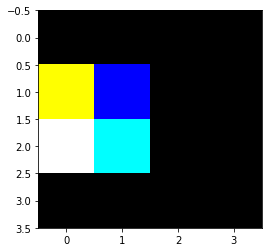

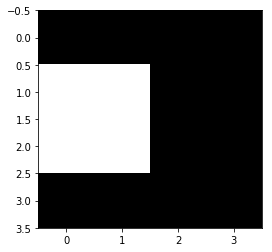

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


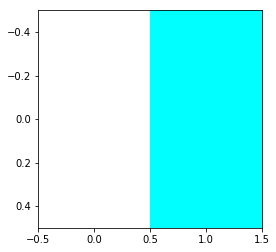

In [138]:
original_image = np.reshape(img_x, (1, 4, 4, 3))
# predicted_image = np.reshape(output_cl1, (1, 4, 4, 3))
visual_image = np.reshape(patch.eval(session=sess2), (1, 1, 2, 3))
visual_label = np.reshape(lbl_x, (1, 4, 4, 3))

# visual_image_conn = np.reshape(output_fully_connected, (1, 120, 120, 3))
# visual_label_conn = np.reshape(lbl_x, (1, 120, 120, 3))
see_output(original_image)
see_output(visual_label)
# see_output(predicted_image)
see_output(visual_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


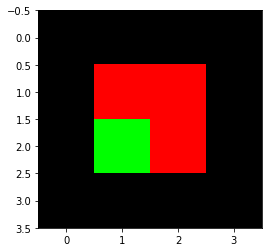

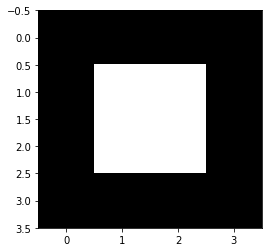

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


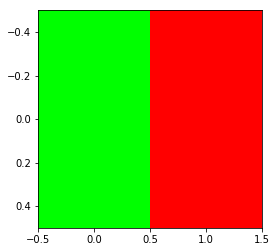

In [92]:
original_image = np.reshape(img_x, (1, 4, 4, 3))
# predicted_image = np.reshape(output_cl1, (1, 4, 4, 3))
visual_image = np.reshape(patch.eval(session=sess2), (1, 1, 2, 3))
visual_label = np.reshape(lbl_x, (1, 4, 4, 3))

# visual_image_conn = np.reshape(output_fully_connected, (1, 120, 120, 3))
# visual_label_conn = np.reshape(lbl_x, (1, 120, 120, 3))
see_output(original_image)
see_output(visual_label)
# see_output(predicted_image)
see_output(visual_image)